# ABM + DiffEq
https://juliadynamics.github.io/Agents.jl/stable/examples/diffeq/

In [1]:
using Agents
using Distributions
using CairoMakie
using OrdinaryDiffEq
using DiffEqCallbacks
CairoMakie.activate!(px_per_unit = 1.0)

Fisher agents

In [2]:
@agent struct Fisher(NoSpaceAgent)
    competence::Int
    yearly_catch::Float64
end

Set fishing quota

In [3]:
function fish!(integrator, model)
    integrator.p[2] = integrator.u[1] > model.min_threshold ?
        sum(a.yearly_catch for a in allagents(model)) : 0.0
    Agents.step!(model, 1)
end

fish! (generic function with 1 method)

Fish population change

In [4]:
function fish_stock!(ds, s, p, t)
    max_population, h = p
    ds[1] = s[1] * (1 - (s[1] / max_population)) - h
end

fish_stock! (generic function with 1 method)

Agents catch the fish

In [5]:
function agent_cb_step!(agent, model)
    agent.yearly_catch = rand(abmrng(model), Poisson(agent.competence))
end

agent_cb_step! (generic function with 1 method)

ABM model embedded in the callback

In [6]:
function initialise_cb(; min_threshold = 60.0, nagents = 50)
    model = StandardABM(Fisher; agent_step! = agent_cb_step!,
                        properties = Dict(:min_threshold => min_threshold))
    for _ in 1:nagents
        competence = floor(rand(abmrng(model), truncated(LogNormal(), 1, 6)))
        add_agent!(model, competence, 0.0)
    end
    return model
end

initialise_cb (generic function with 1 method)

Setup the problem

In [7]:
modelcb = initialise_cb()
tspan = (0.0, 20.0 * 365.0)
initial_stock = 400.0
max_population = 500.0
prob = OrdinaryDiffEq.ODEProblem(fish_stock!, [initial_stock], tspan, [max_population, 0.0])

# Each Dec 31st, we call fish! that adds our catch modifier to the stock, and steps the ABM model
fish = DiffEqCallbacks.PeriodicCallback(i -> fish!(i, modelcb), 364)
# Stocks are replenished again
reset = DiffEqCallbacks.PeriodicCallback(i -> i.p[2] = 0.0, 365)

@time sol = solve(prob, Tsit5();  callback = CallbackSet(fish, reset))

  1.709629 seconds (4.27 M allocations: 231.112 MiB, 5.28% gc time, 99.90% compilation time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 2272-element Vector{Float64}:
    0.0
    0.1379730351325356
    0.5564761658770004
    1.1196169933783673
    1.7672551586109673
    2.552567516636946
    3.4680808539852217
    4.564946454459349
    5.876373627177295
    7.483768553665588
    ⋮
 7281.459006996179
 7282.197294163767
 7283.942221584402
 7285.520024239693
 7287.608175178624
 7289.96186877112
 7292.907071070456
 7296.453399136367
 7300.0
u: 2272-element Vector{Vector{Float64}}:
 [400.0]
 [410.58300851936434]
 [437.32809938708135]
 [462.27758078114454]
 [479.52406721317647]
 [490.4502350704483]
 [496.1319303647314]
 [498.7002281857691]
 [499.64738194876736]
 [499.9274082148435]
 ⋮
 [423.339452321387]
 [406.3894606985359]
 [386.96088638704657]
 [380.02941280323097]
 [376.4282698529878]
 [375.0946250321595]
 [374.6378471851546]
 [374.5241043223786]
 [374.50353927056676]

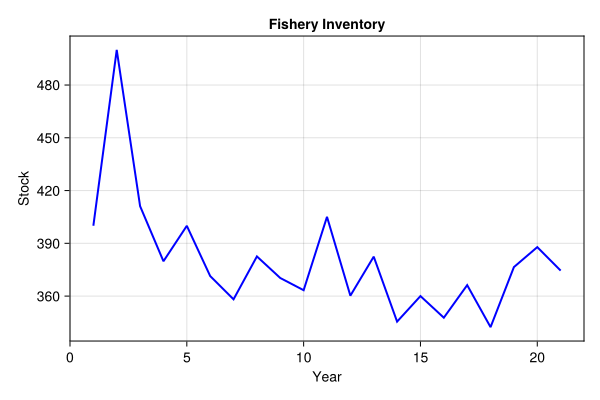

In [8]:
discrete = vcat(sol(0:365:(365 * 20))[:,:]...)
f = Figure(size = (600, 400))
ax = f[1, 1] = Axis(
        f,
        xlabel = "Year",
        ylabel = "Stock",
        title = "Fishery Inventory",
    )
lines!(ax, discrete, linewidth = 2, color = :blue)
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*